In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CS231n/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CS231n


In [4]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

In [35]:
data = pd.read_csv('data/SPX_vol_surface.csv')
vix_data = pd.read_csv('data/VIX.csv')

In [36]:
max_ivol = data.impl_volatility.max()

In [37]:
unique_dates = data.date.unique()
unique_deltas = data.delta.unique()
unique_tenors = data.days.unique()

## Process data into a matrix... to plug into a CNN and skip the visualization step

In [38]:
num_dates = unique_dates.shape[0]
num_deltas = unique_deltas.shape[0]
num_tenors = unique_tenors.shape[0]

print("Unique Dates:", num_dates)
print("Unique Deltas:", num_deltas)
print("Unique Tenors:", num_tenors)

Unique Dates: 505
Unique Deltas: 34
Unique Tenors: 11


In [39]:
# Shape: (num_dates, num_tenors, num_deltas)
vol_surface_matrix = data.set_index(
    ["date", "days", "delta"]).impl_volatility.unstack().values.reshape(
    num_dates, num_tenors, num_deltas)
vol_surface_matrix /= (255/max_ivol)

dates = pd.to_datetime(unique_dates, format='%Y%m%d')

In [40]:
#Data is stored in a pandas dataframe with multiindex. df.loc[date] will give the 2d surface with tenors
#in columns and deltas in rows

midx = pd.MultiIndex.from_product([dates, unique_deltas])

data = pd.DataFrame(index = midx, columns = unique_tenors, dtype='float')
for i in range(len(dates)):
    data.loc[dates[i]] = vol_surface_matrix.squeeze()[i].T

In [41]:
data.head(4)

10        30        60        91        122       152  \
2020-01-02 -90  0.000494  0.000381  0.000469  0.000476  0.000477  0.000485   
           -85  0.000431  0.000379  0.000457  0.000473  0.000478  0.000488   
           -80  0.000391  0.000384  0.000456  0.000477  0.000487  0.000497   
           -75  0.000379  0.000393  0.000463  0.000488  0.000501  0.000512   

                     182       273       365       547       730  
2020-01-02 -90  0.000490  0.000495  0.000502  0.000513  0.000527  
           -85  0.000494  0.000507  0.000517  0.000534  0.000549  
           -80  0.000505  0.000522  0.000533  0.000557  0.000577  
           -75  0.000519  0.000540  0.000553  0.000580  0.000606

In [26]:
data.to_csv('processed_data.csv')

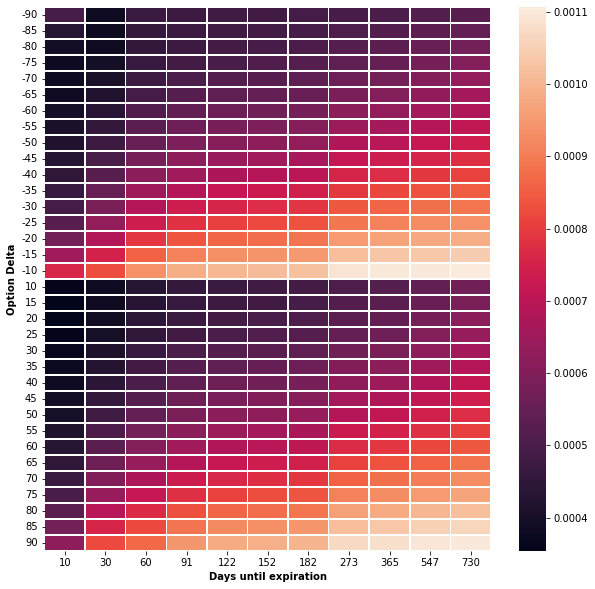

In [21]:
import seaborn as sn

example_vol_heatmap = data.loc['2020-01-02']
example_vol_heatmap = example_vol_heatmap.reset_index(level=0, drop=True)

plt.figure(figsize=(10,10))
ax = sn.heatmap(example_vol_heatmap, linewidth=0.5)
ax.set_xlabel('Days until expiration', 
               fontweight ='bold')
ax.set_ylabel('Option Delta', 
               fontweight ='bold')
plt.show()

In [22]:
data2 = pd.read_csv('processed_data.csv')

In [23]:
data2

,Unnamed: 0,Unnamed: 1,10,30,60,91,122,152,182,273,365,547,730
0,2020-01-02,-90,0.000494,0.000381,0.000469,0.000476,0.000477,0.000485,0.000490,0.000495,0.000502,0.000513,0.000527
1,2020-01-02,-85,0.000431,0.000379,0.000457,0.000473,0.000478,0.000488,0.000494,0.000507,0.000517,0.000534,0.000549
2,2020-01-02,-80,0.000391,0.000384,0.000456,0.000477,0.000487,0.000497,0.000505,0.000522,0.000533,0.000557,0.000577
3,2020-01-02,-75,0.000379,0.000393,0.000463,0.000488,0.000501,0.000512,0.000519,0.000540,0.000553,0.000580,0.000606
4,2020-01-02,-70,0.000381,0.000405,0.000476,0.000503,0.000519,0.000530,0.000537,0.000562,0.000576,0.000604,0.000632
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17165,2021-12-31,70,0.000707,0.000815,0.000914,0.000986,0.001031,0.001058,0.001075,0.001141,0.001165,0.001182,0.001186
17166,2021-12-31,75,0.000777,0.000891,0.000994,0.001067,0.001113,0.001138,0.001154,0.001224,0.001247,0.001260,0.001261
17167,2021-12-31,80,0.000908,0.001004,0.001097,0.001164,0.001209,0.001231,0.001246,0.001323,0.001343,0.001348,0.001346
17168,2021-12-31,85,0.001129,0.001177,0.001233,0.001283,0.001322,0.001340,0.001353,0.001440,0.001458,0.001446,0.001440
